### ライブラリの準備

###モジュールのインポートとGoogleドライブのマウント

In [1]:
import os
import torch.autograd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime
#from tqdm import tqdm
from tqdm.notebook import tqdm
import pickle
import copy
import gc
import random
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import skimage.transform
from collections import deque
from typing import Sequence, Dict, Tuple, Union, Optional
#from argparse import Namespace
from dataclasses import dataclass, field
from sacrebleu.metrics import BLEU
from evaluate import load
import jiwer
from comet import download_model, load_from_checkpoint

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import models
import torchvision.transforms as T
import torchvision.datasets as dataset
from torchvision.transforms import v2

#from timm.scheduler import CosineLRScheduler
from transformers import  get_linear_schedule_with_warmup

#from transformers import AutoImageProcessor, AutoModel, AutoProcessor, CLIPVisionModel
#from transformers import AutoTokenizer, CLIPVisionModel, AutoModelForCausalLM
from transformers import BertTokenizer, BertModel, CLIPVisionModel, BertForPreTraining

import sys
from evaluate import load

import util
import levenshtein
from nltk import bleu_score
from torchmetrics.multimodal import CLIPScore
import ssl
from torch.amp import autocast, GradScaler
from collections import OrderedDict
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider
import multiprocessing
from concurrent.futures import ProcessPoolExecutor
from pycocoevalcap.cider.cider import Cider
import json
import collections
from collections import Counter
import plotly
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend
fn = bleu_score.SmoothingFunction().method7
import time
from pycocoevalcap.spice.spice import Spice
#logging.getLogger('rouge_score.rouge_scorer').setLevel(logging.WARNING)
#logging.set_verbosity_warning()

2026-02-08 01:56:28.967708: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-08 01:56:29.025233: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-08 01:56:30.224398: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
class PositionalEmbedding(nn.Module):
    '''
    位置埋め込み （Positional embedding）
    dim_embedding: 埋込み次元
    max_len      : 入力の最大系列長
    '''
    def __init__(self, dim_embedding: int, max_len: int=2048):
        super().__init__()

        self.pos_emb = nn.Embedding(max_len, dim_embedding)

    '''
    位置エンコーディングの順伝播
    x: 位置エンコーディングを埋め込む対象のテンソル,
       [バッチサイズ, 系列長, 埋め込み次元]
    '''
    def forward(self, x: torch.Tensor):
        seq = x.shape[1]
        positions = torch.arange(start=0, end=seq, step=1, device=x.device).to(torch.long)
        positions = self.pos_emb(positions)[:seq,:]
        
        return positions

In [3]:
model_id = "google-bert/bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained(model_id)
pad_token_id = tokenizer.pad_token_id
cls_token_id = tokenizer.cls_token_id
sep_token_id = tokenizer.sep_token_id
sos_token_id = tokenizer.encode( [ "[unused0]" ] )[1]
eos_token_id = tokenizer.encode( [ "[unused1]" ] )[1]
a_token_id = tokenizer.encode( [ "a" ] )[1]
the_token_id = tokenizer.encode( [ "the" ] )[1]
and_token_id = tokenizer.encode( [ "and" ] )[1]
in_token_id = tokenizer.encode( [ "in" ] )[1]
we_token_id = tokenizer.encode( [ "we" ] )[1]
i_token_id = tokenizer.encode( [ "i" ] )[1]
he_token_id = tokenizer.encode( [ "he" ] )[1]
she_token_id = tokenizer.encode( [ "she" ] )[1]
it_token_id = tokenizer.encode( [ "it" ] )[1]
they_token_id = tokenizer.encode( [ "they" ] )[1]
period_token_id = tokenizer.encode( [ "." ] )[1]
comma_token_id = tokenizer.encode( [ "," ] )[1]
dbl_token_id = tokenizer.encode( [ '"' ] )[1]
sgl_token_id = tokenizer.encode( [ "'" ] )[1]


# 辞書サイズを保存
vocab_size = len( tokenizer )

class ComputeReward(nn.Module):
    def __init__(self, device, reward_t = 'ordinary', decode_t = 'ordinary', sentence_level_metric="bleu", 
                 repeat_thresh = [4,2,2,2], repeat_weight = [0.5, 1, 1, 2], cider_coef = 1.0, rouge_coef = 1.0, clip_coef = 2.0, 
                 bert_coef = 1.0, use_amp = True ):
        super().__init__()
        self.metric = sentence_level_metric
        self.tokenizer = tokenizer
        self.tgt_lang = "en"
        self.device = device

        if sentence_level_metric =='special':
            #self.bleu = BLEU(effective_order="True")
            self.scorer = Cider()
            #self.meteor = load('meteor')
            self.rougeL = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
            self.bert = load('bertscore')
            self.metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch32").to(self.device)
            for param in self.metric.parameters():
                param.requires_grad = False
            self.spider = Spice()
        elif sentence_level_metric == 'bleu':
            self.bleu = BLEU(effective_order="True")
        elif sentence_level_metric == 'meteor':
            self.meteor = load('meteor')
        elif sentence_level_metric == 'rouge':
            self.rougeL = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
        elif sentence_level_metric == 'cider':
            self.scorer = Cider() 
        elif sentence_level_metric == 'ter':
            #self.ter = load('ter')
            pass
        elif sentence_level_metric == 'bert':
            #self.bert = load('bertscore')
            pass
        elif sentence_level_metric == 'bleurt':
            #self.bleurt = load('bleurt', module_type='metric', checkpoint='bleurt-large-128')
            pass
        elif self.metric == "comet":
            model_path = download_model("Unbabel/wmt22-comet-da")
            self.comet = load_from_checkpoint(model_path)
        self.reward_t = reward_t
        self.repeat_thresh = repeat_thresh
        self.repeat_weight = repeat_weight
        self.decode_t = decode_t
        self.cider_coef = cider_coef
        self.rouge_coef = rouge_coef
        self.clip_coef = clip_coef
        self.bert_coef = bert_coef
        self.use_amp = use_amp
    
    def _compute_reward_ord(self, preds, targets, imgs2, sources=None):
        """
        Compute reward metric for a batch of prediction and target sentences
        """
        model_name = "distilbert-base-uncased"
        # detokenize (convert to str) preds & targets
        if self.decode_t == 'no-endoftext':
            preds_str = [self.tokenizer.decode(
                [pred[i] for i in range( 1,  len( pred )  ) if not (pred[i-1] == endoftext_token_id and pred[i] == endoftext_token_id) ]
                ) for pred in preds]
            targets_str = [self.tokenizer.decode(
                [target[i] for i in range( 1,  len( target )  ) if not (target[i-1] == endoftext_token_id and target[i] == endoftext_token_id) ]
                ) for target in targets]
        elif self.decode_t == 'no-pad':
            preds_str = [self.tokenizer.decode(
                [ i for i in pred \
                 if i != pad_token_id \
                 and i != eos_token_id ] \
                ) for pred in preds]
            preds_str2 = [self.tokenizer.decode(
                [ i for i in pred \
                 if  i != eos_token_id  ] \
                 , skip_special_tokens = True ) for pred in preds]
            targets_str = [self.tokenizer.decode(
                [ i for i in target \
                if i != pad_token_id \
                 and i != eos_token_id ]       
                ) for target in targets]
        else:
            preds_str = [self.tokenizer.decode(pred) for pred in preds]
            targets_str = [self.tokenizer.decode(target) for target in targets]
        sources_str = [self.tokenizer.decode(source, ref="src") for source in sources] if sources is not None else None
        #print( "preds size:", preds.size() )
        #print( "targets size:", targets.size() )
        
        #print(f'1st target sent: {targets_str[0]}')
        #print(f'1st pred sent: {preds_str[0]}')

        # compute reward metric
        seq_len = preds.shape[1]

        if self.metric == 'special':
            #reward_bleu = [[self.bleu.sentence_score(pred, [target]).score] * seq_len for pred, target in zip(preds_str, targets_str)]
            #reward_bleu = [[bleu_score.sentence_bleu( target, pred, smoothing_function=fn)] * seq_len for pred, target in zip(preds_str, targets_str)]
            #reward_bleu = torch.tensor(reward_bleu).to(self.device) / 100.0
            #wer_scores = [jiwer.wer(target, pred) for pred, target in zip(targets_str, preds_str)]
            #reward = [[score] * seq_len for score in wer_scores]
            #reward_wer = - torch.tensor( reward ).to(self.device)
            #start_time = time.time()
            pred_dict = { str(i): [item] for i, item in enumerate( preds_str)}
            target_dict = { str(i): [item] for i, item in enumerate( targets_str)}
            score, scores = self.scorer.compute_score(target_dict, pred_dict)
            reward_cider = torch.tensor( scores ).to( self.device )[:,None].expand( -1, seq_len )
            #end_time = time.time()
            #print( "cider time:", end_time - start_time )
            #start_time = time.time()
            reward_rouge = [[self.rougeL.score(target, pred)['rougeL'][0]]  * seq_len for pred, target in zip(preds_str, targets_str)]
            reward_rouge = torch.tensor( reward_rouge ).to( self.device )
            #end_time = time.time()
            #print( "rouge time:", end_time - start_time )
            #start_time = time.time()
            with autocast(str(self.device),enabled=self.use_amp):
                with torch.no_grad():
                    #clip_scores = [[self.metric( img2, pred).detach()] * seq_len for img2, pred in zip( imgs2, preds_str2 )]
                    #tmp = self.metric( imgs2, preds_str2 )
                    #print( "tmp size:", tmp.size() )
                    #clip_scores = [[self.metric( imgs2, preds_str2 ).detach()] * seq_len ]
                    processed = self.metric.processor(text=preds_str2, images=imgs2, return_tensors="pt", padding=True, \
                                                      truncation=True, max_length=77 ).to(self.device)
                    outputs = self.metric.model(**processed)
                    # 特徴量の正規化
                    image_features = outputs.image_embeds / outputs.image_embeds.norm(p=2, dim=-1, keepdim=True)
                    text_features = outputs.text_embeds / outputs.text_embeds.norm(p=2, dim=-1, keepdim=True)
                    # 3. コサイン類似度を一括計算 (100倍してマイナスをカットするのが CLIPScore の定義)
                    # 各画像ペアの個別スコア (Batch Size,) が得られる
                    individual_scores = torch.clamp( (image_features * text_features).sum(axis=-1), min=0)
                    #print( "individual_scores size:", individual_scores.size() )
                    clip_scores = individual_scores[:,None].expand( -1, seq_len ).to( self.device ) / 100.0
                    #print( "clip_scores size:", clip_scores.size() )
                    reward_clip = clip_scores
                    #end_time = time.time()
                    #print( "clip time:", end_time - start_time )
                    #start_time = time.time()
                    bert_scores = self.bert.compute(predictions=preds_str, references=targets_str, use_fast_tokenizer=True, \
                                            model_type=model_name, lang='en',  device=self.device)['f1']
                    reward_bert = torch.tensor( bert_scores )[:,None].expand( -1, seq_len ).to( self.device )
                    #end_time = time.time()
                    #print( "bert time:", end_time - start_time )
            #image = torch.randint(255, (3, 224, 224), generator=torch.Generator().manual_seed(42))
            #score = metric(image, "a photo of a cat")
            #average_score, scores = self.spice.compute_score(target_dict, pred_dict)
            #print( "average_score:", average_score ) 
            #reward_spice = torch.tensor( scores ).to( self.device )[:,None].expand( -1, seq_len )
            #meteor_scores = [self.meteor.compute(predictions=[preds], references=[targets])['meteor'] for preds, targets in zip(preds_str, targets_str)]
            #reward_meteor = [[score] * seq_len for score in meteor_scores]
            #reward_meteor = torch.tensor( reward_meteor ).to( self.device )
            #reward = reward_bleu + reward_cider
            #print( "reward_bleu:", reward_bleu )
            #print( "reward_cider:", reward_cider )
            #print( "reward_meteor:", reward_meteor )
            #reward = reward_meteor + reward_cider
            #print( "self.bert_coef:", self.bert_coef )
            #print( "reward_bert:", reward_bert )
            #reward = self.clip_coef * reward_clip + self.bert_coef * reward_bert
            reward = self.cider_coef * reward_cider + self.rouge_coef * reward_rouge \
                + self.clip_coef * reward_clip + self.bert_coef * reward_bert
            reward2 = reward_cider + reward_rouge + reward_bert + reward_clip
            #score, scores = self.spider.compute_score(gts, res)
            #reward_rouge = [[self.spider.compute_score(target, pred)[1]]  * seq_len for pred, target in zip(preds_str, targets_str)]
            #reward2 = reward_rouge + reward_bert + reward_clip
            #reward = self.rouge_coef * reward_rouge + self.cider_coef * reward_cider + self.clip_coef * reward_clip \
            #    + self.bert_coef * reward_bert
            #reward = reward_bleu + reward_cider
            #reward = reward_bleu + reward_cider + reward_meteor
            #reward = reward_wer + reward_cider
            #reward = reward_bleu + reward_wer + reward_cider
            #reward = reward_bleu + reward_wer + reward_cider + reward_meteor
            #print( "wer:", reward_wer )
            #print( "cider:", reward_cider )
        elif self.metric == "bleu":
            reward = [[self.bleu.sentence_score(pred, [target]).score] * seq_len for pred, target in zip(preds_str, targets_str)]
        
        elif self.metric == "meteor":
            meteor_scores = [self.meteor.compute(predictions=[preds], references=[targets])['meteor'] for preds, targets in zip(preds_str, targets_str)]
            reward = [[score] * seq_len for score in meteor_scores]
            
        elif self.metric == "rouge":
            #rouge_scores = self.rouge.compute(predictions=preds_str, references=targets_str, use_aggregator=False )['rougeL']
            reward = [[self.rouge.score(target, pred)['rougeL'][0]]  * seq_len for pred, target in zip(preds_str, targets_str)]
        
        elif self.metric == "wer":
            wer_scores = [jiwer.wer(target, pred) for pred, target in zip(targets_str, preds_str)]
            reward = [[score] * seq_len for score in wer_scores]
            reward = - torch.tensor( reward )

        elif self.metric == 'cider':
            pred_dict = { str(i): [item] for i, item in enumerate( preds_str)}
            target_dict = { str(i): [item] for i, item in enumerate( targets_str)}
            #score, all_scores = parallel_cider_evaluation( target_dict, pred_dict )
            score, scores = self.scorer.compute_score(target_dict, pred_dict)
            reward = torch.tensor( scores ).to( self.device )[:,None].expand( -1, seq_len )
            
        #elif self.metric == "bert":
        #    bert_scores = self.bert.compute(predictions=preds_str, references=targets_str, lang='en')['f1']
        #    reward = [[score] * seq_len for score in bert_scores]

        #elif self.metric == "bleurt":
        #    bleurt_scores = self.bleurt.compute(predictions=preds_str, references=targets_str)['scores']
        #    reward = [[score] * seq_len for score in bleurt_scores]
            
        elif self.metric == "comet":
            data = [{"src": source, "mt": pred, "ref": target} for source, pred, target in zip(sources_str, preds_str, targets_str)]
            reward = self.comet.predict(data, batch_size=8, gpus=1)['scores']
            reward = [[score] * seq_len for score in reward]
        else:
            raise ValueError(f"metric {self.metric} not supported")
        if self.metric != 'cider' and self.metric != 'special':
            reward = torch.tensor(reward).to(self.device)
        
        #print( "reward size:", reward.size() )
        #return reward
        return reward, reward2

    def my_index(self, list1, target ):
        if target in list1:
            return list1.index( target )
        else:
            return 0
    
    def compute_length_reward( self, preds, targets ):

        #def differentiable_argamx( logits, tau ):

        #    tmp = F.gumbel_softmax( logits, tau, hard=True )
        #    tmp1 = torch.arange( 0, logits.size(2) )[None,None] * tmp
        #    tokens = torch.sum( tmp1, dim = 2 )

        #    return tokens
        '''
        pred_index = preds == eos_token_id
        first_index = ( pred_index.int().cumsum(dim = 1 ) == 1 ) & pred_index
        #print( first_index )
        arange_index = torch.arange( 0, first_index.size(1), device = self.device )
        pred_lengths = torch.sum( first_index.float() * arange_index.float(), dim = 1 ) / preds.size(1)
        #print( pred_lengths ) 
        
        reward = pred_lengths[:,None].expand( -1, preds.size(1) )
        
        return reward         
        '''
        
        pred_index = preds == eos_token_id
        first_index = ( pred_index.int().cumsum(dim = 1 ) == 1 ) & pred_index
        arange_index = torch.arange( 0, first_index.size(1), device = self.device )
        pred_lengths = torch.sum( first_index.float() * arange_index.float(), dim = 1 ) / preds.size(1)
        
        target_index = targets == eos_token_id
        first_index = ( target_index.int().cumsum(dim = 1 ) == 1 ) & target_index
        target_lengths = torch.sum( first_index.float() * arange_index.float(), dim = 1 ) / targets.size(1)
        #target_lengths = 1.1 * torch.sum( first_index.float() * arange_index.float(), dim = 1 ) / targets.size(1)
        #target_lengths = torch.clamp( target_lengths, max = 1.0 )
        #target_lengths = torch.full((preds.size(0),), self.target_length / preds.size(1), device = self.device )
        
        reward_lengths = - nn.MSELoss(reduction='none')( pred_lengths, target_lengths )
        #reward_lengths = - torch.abs( pred_lengths - target_lengths )
        
        reward = reward_lengths[:,None].expand( -1, preds.size(1) )
        
        return reward  
        
        #reward = torch.tensor( [ self.my_index( pred.tolist(), eos_token_id ) for pred in preds ] ).to(self.device )
        #reward = reward[:,None].expand( -1, preds.size(1) ).float()
        
        ##tokens = differentiable_argamx( logits, tau ) #logits から token を算出。微分可能 B * T
        
        '''
        tmp1 = torch.abs( preds - tokenizer.pad_token_id ) # pad だけ 0 あとは1以上の正の数 B * T
        tmp2 = torch.abs( preds - eos_token_id ) # pad だけ 0 あとは1以上の正の数 B * T
        tmp = tmp1 * tmp2
        pad_preds = F.sigmoid( 10 - 100 * tmp ) # pad のところだけ 1, あとは 0。 B * T  
        reward = ( torch.tensor( preds.size(1))[None] - torch.sum( pad_preds, dim = 1 ))[:,None].expand( -1, preds.size(1) ) 
        '''
        # 固定長97 から　pad と eos の長さを引いて、文章の長さ。文章の長さが大きいほどよい。
        
        #tmp1 = torch.abs( targets - tokenizer.pad_token_id ) # pad だけ 0 あとは1以上の正の数 B * T
        #tmp2 = torch.abs( targets - eos_token_id ) # pad だけ 0 あとは1以上の正の数 B * T
        #tmp = tmp1 * tmp2
        #pad_targets = F.sigmoid( 10 - 100 * tmp ) # pad のところだけ 1, あとは 0。 B * T
        
        #reward = - nn.MSELoss( reduction = 'none' )( pad_preds, pad_targets )
        
        #return  reward
    
    def calc_ngram_repeat( self, preds ):

        bsz, seq_len = preds.size()
        
        ngram_cnt = torch.zeros( (bsz), device = preds.device, dtype = torch.float )
        for n in range( 2, 4 ):
            for i, pred in enumerate( preds ):
                pred = pred.tolist()
                ngrams = zip(*[pred[i:] for i in range(n)])
                counts = Counter(ngrams)
                count_sum = 0
                for count in counts.values():
                    if count >= self.repeat_thresh:
                        count_sum = count_sum + count
                ngram_cnt[i] = ngram_cnt[i] + count_sum

        return - ngram_cnt[:,None].expand( -1, seq_len ) / seq_len

    def unique_ngram_ratio(self, preds):
        
        bsz, seq_len = preds.size()
        ng = 5
        unr = torch.zeros( (bsz, ng), device=preds.device, dtype=torch.float)

        pred_index = preds == eos_token_id
        first_index = ( pred_index.int().cumsum(dim = 1 ) == 1 ) & pred_index
        arange_index = torch.arange( 0, first_index.size(1), device = self.device )
        pred_lengths = torch.sum( first_index * arange_index, dim = 1 )
        
        for b in range( bsz ):
            for n in range( 0, ng - 1 ): # n は ngram - 1
                if pred_lengths[b] > 0:
                    #print( "pred_lengths[b]:", pred_lengths[b] )
                    pred_tmp = preds[b,:pred_lengths[b]]
                    #print( "pred_tmp:", pred_tmp )
                else:
                    pred_tmp = preds[b]
                ngram_tensor = pred_tmp.unfold(0, n + 1, 1)
                ngram_count = len( ngram_tensor )
                unique_count = len( torch.unique( ngram_tensor ) )
                #unique_count = len( set( map(tuple, ngram_tensor.tolist())))
                unr[b,n] = unique_count / ngram_count

        return torch.mean( unr, dim = 1)[:, None].expand(-1, seq_len)
    
    def calc_ngram_repeat_fast(self, preds):
        bsz, seq_len = preds.size()
        ngram_cnt = torch.zeros(bsz, device=preds.device, dtype=torch.float)
        
        for n in range(1, 5):
            # 無視するトークンのリスト
            #ignore_ids = [self.pad_token_id, self.eos_token_id, self.cls_token_id, self.sep_token_id]
            if n == 1:
                ignore_ids = [pad_token_id, eos_token_id, cls_token_id, sep_token_id, a_token_id, the_token_id, \
                              period_token_id, comma_token_id, and_token_id, in_token_id ]
            else:
                ignore_ids = [pad_token_id, eos_token_id, cls_token_id, sep_token_id]
            
            # 1. 無視すべきトークンの位置を特定 (bsz, seq_len)
            # ignore_mask[b, i] が True なら、そのトークンは無視対象
            ignore_mask = torch.zeros_like(preds, dtype=torch.bool)
            for idx in ignore_ids:
                ignore_mask |= (preds == idx)
            
            if seq_len < n:
                continue
            
            # n-gram を抽出 (bsz, num_ngrams, n)
            ngrams = preds.unfold(dimension=1, size=n, step=1)
            
            # 2. 各 n-gram に無視対象トークンが含まれているか判定
            # n-gram内のいずれかが ignore_mask で True なら True
            # (bsz, num_ngrams)
            ngram_ignore_mask = ignore_mask.unfold(dimension=1, size=n, step=1).any(dim=-1)
        
            for b in range(bsz):
                # このバッチの有効な n-gram だけを抽出
                valid_ngrams = ngrams[b][~ngram_ignore_mask[b]]
                
                if valid_ngrams.size(0) == 0:
                    continue
                
                # ユニークな n-gram とそのカウントを取得
                unique_ngrams, counts_per_ngram = torch.unique(valid_ngrams, dim=0, return_counts=True)
                
                # 閾値以上のカウントを合計
                mask = counts_per_ngram >= self.repeat_thresh[n-1]
                ngram_cnt[b] += counts_per_ngram[mask].sum().float() * self.repeat_weight[n-1]

        penalty = - torch.clamp( torch.pow( 2, ngram_cnt -1 ) / seq_len, max = 1.0 )    
        
        return penalty[:, None].expand(-1, seq_len)
    
    def calc_cnt_repeat( self, preds ):

        B, T = preds.size()

        repeat_count = torch.zeros( ( bsz, vocab_size ), device = preds.device )
        for i, pred in enumerate( preds ):
            repeat_count0 = torch.bincount( pred )
            repeat_count[i,:len(repeat_count0)] = repeat_count0 

        repeat_count[:,pad_token_id] = 0
        repeat_count[:,eos_token_id] = 0
        repeat_count[:,cls_token_id] = 0
        repeat_count[:,sep_token_id] = 0
        thresh_masks = repeat_count >= self.repeat_thresh
        repeat_count = repeat_count * thresh_masks

        repeat = torch.sum( repeat_count, dim = 1 )
        
        return - repeat[:,None].expand( -1, T ).float() / seq_len
        '''
        B, T = preds.size()

        repeat_count = torch.zeros( ( bsz, vocab_size ), device = preds.device )
        for i, pred in enumerate( preds ):
            repeat_count0 = torch.bincount( pred )
            repeat_count[i,:len(repeat_count0)] = repeat_count0 

        repeat_times = torch.sum( repeat_count >= self.repeat_thresh, dim = 1 )
        #print( "repeat_times:",repeat_times )

        pad_count = repeat_count[:,pad_token_id]
        pad_times = (pad_count >= self.repeat_thresh).long()
        #print( "pad_times:", pad_times )

        eos_count = repeat_count[:,eos_token_id]
        eos_times = (eos_count >= self.repeat_thresh).long()
        #print( "eos_times:", eos_times )

        repeat = repeat_times - pad_times - eos_times
        #print( repeat )

        #print( "repeat size:", repeat.size() )
        
        return - repeat[:,None].expand( -1, T ).float()
        '''
        '''
        tokens = preds
        #tokens[0,0] = 1000
        #tokens[0,1] = 1000
        #print( "tokens size:", tokens.size() )
        #print( "tokens[:,0]:", tokens[:,0] )
    
        cnt = torch.zeros( (B, T),  device=preds.device, dtype=torch.float16 )
        for i in range( T ):
            cntj = torch.zeros( (B),  device=preds.device, dtype=torch.float16 )
            num_j = 0
            for j in range( max( 0, i - self.c ), min(  T, i + self.c ) ):
                if j != i:
                    ##print( "torch.eq", torch.eq( tokens[:,i], tokens[:,j]))
                    #tmp1 = torch.eq( tokens[:,i], tokens[:,j]) 
                    #tmp2 = torch.ne( tokens[:,i], eos_token_id )
                    #tmp3 = torch.ne( tokens[:,i], tokenizer.pad_token_id )
                    ##print( "tmp1:", tmp1 )
                    ##print( "tmp2:", tmp2 )
                    ##print( "tmp3:", tmp3 )
                    #tmp = (torch.logical_and(torch.logical_and( tmp1 , tmp2 ),tmp3 )).to(torch.float16)
                    if self.decode_t == 'no-endoftext':
                        tmp = ((tokens[:,i] != tokens[:,j] ).to(torch.float) ) * 10 \
                            +  ((tokens[:,i] == endoftext_token_id).to(torch.float) )  * 10
                    elif self.decode_t == 'no-pad':
                        tmp = ((tokens[:,i] != tokens[:,j] ).to(torch.float) ) * 10 \
                            + ((tokens[:,i] == pad_token_id).to(torch.float) )  * 10 \
                            + ((tokens[:,i] == eos_token_id).to(torch.float) ) * 10
                            # tokens[:,i] と tokens[:,j] が同じで、tokens[:,i] が　eos、pad でなければ 0 その他は 10 以上の整数 
                    tmp = F.sigmoid( 10 - 100 * tmp ) # tokens[:,i]とtokens[:,j] が同じで eos pad ではないところだけ 1, あとは 0.
                    #if torch.any( tmp != 0 ):
                    #    print( "tmp:", tmp )
                    cntj = cntj + tmp # repeat の数。[B]  jについて足しこんでいる。
                    #if torch.any( cntj != 0 ):
                    #    print( "cntj:", cntj )
                    num_j = num_j + 1
            cnt[:,i] = cntj / num_j # repeat の数。[B] i について足しこんでいる。
        
        #mask = cnt != 0
        #print( "cnt mask:", cnt[mask] )
        #return - torch.mean( cnt, dim = 1 ) # 
        return - torch.mean( cnt, dim = 1 )[:,None].expand(-1, T )  # B * T repeat の数が少ないほど良い。repeat の数の -1 倍が多いほどよい。
        '''
    def forward(self, top_probs, sampled_beam_idx, top_indices, targets, imgs2,  sources=None, masks=None):
        """
        outputs: batch x len x d_model
        targets: batch x len
        sources: batch x len
        masks:   batch x len
        """
        self.device = sampled_beam_idx.device
        # input to device
        targets = targets.to(self.device)
        bsz, seq_len, beam = top_probs.size()
        eps = 1e-8

        preds = torch.gather( top_indices, -1, sampled_beam_idx ).squeeze( -1 )
        tmp = torch.clamp( top_probs, eps )
        top_log_probs = torch.log( tmp )
        sample_log_probs = torch.gather( top_log_probs, -1, sampled_beam_idx ).squeeze( -1 )

        if self.reward_t == 'ordinary':
            reward_ord = self.compute_reward(preds, targets, imgs2, sources)   #  bsz
            reward_repeat = torch.zeros( ( bsz, seq_len ),  device = preds.device, dtype=torch.float ) # bsz * seq_len
            reward_length = torch.zeros( ( bsz, seq_len ),  device = preds.device, dtype=torch.float ) # bsz * seq_len
            reward_unr = torch.zeros( ( bsz, seq_len ),  device = preds.device, dtype=torch.float ) # bsz * seq_len
        elif self.reward_t == "ord+rep":
            reward_ord = self._compute_reward_ord(preds, targets, imgs2, sources)  # bsz * seq_len
            #reward_repeat = self.calc_cnt_repeat( preds ) + self.calc_ngram_repeat_fast( preds ) # bsz * seq_len
            reward_repeat = self.calc_ngram_repeat_fast( preds ) # bsz * seq_len
            reward_length = torch.zeros( ( bsz, seq_len ),  device = preds.device, dtype=torch.float ) # bsz * seq_len
            #reward = reward_ord + reward_repeat - b # bsz * seq_len
            reward_unr = torch.zeros( ( bsz, seq_len ),  device = preds.device, dtype=torch.float ) # bsz * seq_len
        elif self.reward_t == "ord+rep+len":
            reward_ord, reward_ord2 = self._compute_reward_ord(preds, targets, imgs2, sources)  # bsz * seq_len
            #reward_ord = self._compute_reward_ord(preds, targets, imgs2, sources)  # bsz * seq_len
            #reward_repeat = self.calc_cnt_repeat( preds ) + self.calc_ngram_repeat_fast( preds ) # bsz * seq_len
            reward_repeat = self.calc_ngram_repeat_fast( preds ) # bsz * seq_len
            reward_length = self.compute_length_reward( preds, targets ) # bsz * seq_len
            reward_unr = torch.zeros( ( bsz, seq_len ),  device = preds.device, dtype=torch.float ) # bsz * seq_len
        elif self.reward_t == 'ord+len':
            reward_ord = self._compute_reward_ord(preds, targets, imgs2, sources)  # bsz * seq_len
            #reward_repeat = self.calc_cnt_repeat( preds ) + self.calc_ngram_repeat_fast( preds ) # bsz * seq_len
            reward_repeat = self.calc_ngram_repeat_fast( preds ) # bsz * seq_len
            reward_length = self.compute_length_reward( preds, targets ) # bsz * seq_len
            reward_unr = torch.zeros( ( bsz, seq_len ),  device = preds.device, dtype=torch.float ) # bsz * seq_len
        elif self.reward_t == 'ord+rep+len+unr':
            reward_ord, reward_ord2 = self._compute_reward_ord(preds, targets, imgs2, sources)  # bsz * seq_len
            reward_repeat = self.calc_ngram_repeat_fast( preds ) # bsz * seq_len
            reward_length = self.compute_length_reward( preds, targets ) # bsz * seq_len
            reward_unr = self.unique_ngram_ratio(preds)
        
        ## apply mask
        #if masks is not None:
        #    masks = masks.to(self.device)
        #    probs, targets = probs[masks], targets[masks]
        #    # outputs, targets = outputs[masks], targets[masks]
        #    reward, preds = reward[masks], preds[masks]
       
        return reward_ord, reward_ord2, reward_repeat, reward_length, reward_unr, preds, sample_log_probs

### CaptioningTransformer

In [4]:
def logsumexp(x, dim=1):
    return torch.logsumexp(x.float(), dim=dim).type_as(x)

class DynamicCRF(nn.Module):
    def __init__(self, num_embedding, low_rank=32, beam_size=64, crf_coef=1.0, temp = 0.5):
        super().__init__()

        #low_rank = num_embedding
        self.E1 = nn.Embedding(num_embedding, low_rank)
        self.E2 = nn.Embedding(num_embedding, low_rank)

        self.vocb = num_embedding
        self.rank = low_rank
        self.beam = beam_size
        self.crf_coef = crf_coef
        self.temp = temp

    def extra_repr(self):
        return "vocab_size={}, low_rank={}, beam_size={}".format(
            self.vocb, self.rank, self.beam)

    def forward(self, emissions, top_logits, top_indices, targets, masks, beam=None):
        numerator = self._compute_score(emissions, targets, masks)
        denominator = self._compute_normalizer(emissions, targets, masks, beam )
        beam_probs = self._compute_normalizer2(top_logits, top_indices, targets, masks, beam)

        return numerator - denominator, beam_probs
    
    def forward_decoder(self, emissions, masks=None, beam=None):
        return self._viterbi_decode(emissions, masks, beam)

    def _compute_score(self, emissions, targets, masks=None):
        batch_size, seq_len = targets.size()

        emission_scores = emissions.gather(2, targets[:, :, None])[:, :, 0]  # B x T
        transition_scores = (self.E1(targets[:, :-1]) * self.E2(targets[:, 1:])).sum(2)
       
        scores = emission_scores
        scores[:, 1:] += transition_scores
        
        if masks is not None:
            scores = scores * masks.type_as(scores)

        return scores.sum(-1)
        
    def _compute_normalizer(self, emissions, targets=None, masks=None, beam=None):

        eps = 1e-8
        
        beam = beam if beam is not None else self.beam
        batch_size, seq_len = emissions.size()[:2]
        if targets is not None:
            #_emissions = emissions.scatter(2, targets[:, :, None], np.float('inf'))
            _emissions = emissions.scatter(2, targets[:, :, None], float('inf'))
            beam_targets = _emissions.topk(beam, 2)[1]
            beam_emission_scores = emissions.gather(2, beam_targets)
        else:
            beam_emission_scores, beam_targets = emissions.topk(beam, 2)
        beam_transition_score1 = self.E1(beam_targets[:, :-1])  # B x (T-1) x K x D; position i - 1, previous step.
        beam_transition_score2 = self.E2(beam_targets[:, 1:])   # B x (T-1) x K x D; position i, current step.
        beam_transition_matrix = torch.bmm(
            beam_transition_score1.view(-1, beam, self.rank),
            beam_transition_score2.view(-1, beam, self.rank).transpose(1, 2))
        beam_transition_matrix = beam_transition_matrix.view(batch_size, -1, beam, beam)

        # compute the normalizer in the log-space
        score = beam_emission_scores[:, 0]  # B x K
        for i in range(1, seq_len):
            next_score = score[:, :, None] + beam_transition_matrix[:, i-1]
            next_score = logsumexp(next_score, dim=1) + beam_emission_scores[:, i]
            if masks is not None:
                score = torch.where(masks[:, i:i+1], next_score, score)
            else:
                score = next_score

        return logsumexp(score, dim=1)

    def _compute_top_probs(self, beam_emission_scores, beam_transition_matrix, targets=None, masks=None, beam=None):

        eps = 1e-8
        device = beam_emission_scores.device
        
        beam = beam if beam is not None else self.beam
        batch_size, seq_len = beam_emission_scores.size()[:2]

        traj_tokens, traj_scores = [], []
        finalized_tokens, finalized_scores = [], []

        # compute the normalizer in the log-space
        score = beam_emission_scores[:, 0]  # B x K
        
        for i in range(1, seq_len):
            traj_scores.append(score)
            _score = score[:, :, None] + beam_transition_matrix[:, i-1] # bsz, beam, beam

            # greedy selection
            #_score, _index = _score.max(dim=1) # bsz, beam     bsz, beam 

            # multinomial selection
            B, C, W = _score.shape
            flat_score = _score.permute(0, 2, 1).reshape(-1, C)
            probs = F.softmax(flat_score / self.temp, dim=-1)
            _index_flat = torch.multinomial(probs, num_samples=1)
            _score_flat = torch.gather(flat_score, -1, _index_flat)
            _index = _index_flat.view(B, W)
            _score = _score_flat.view(B, W)

            _score = _score + beam_emission_scores[:, i] # bsz, beam
            
            #if masks is not None:
            #    score = torch.where(masks[:, i: i+1], _score, score)
            #    index = torch.where(masks[:, i: i+1], _index, dummy)
            #else:
            score, index = _score, _index
            traj_tokens.append(index)
        
        all_scores = traj_scores
        all_scores.append( score )
        all_scores = torch.stack( all_scores, dim = 0 ).transpose( 0, 1 ).to(device)
        #beam_probs = F.softmax( all_scores / self.temp, dim = 2 )
        beam_probs = F.softmax( all_scores, dim = 2 )

        # now running the back-tracing and find the best
        best_score, best_index = score.max(dim=1)
        finalized_tokens.append(best_index[:, None])
        finalized_scores.append(best_score[:, None])

        for idx, scs in zip(reversed(traj_tokens), reversed(traj_scores)):
            previous_index = finalized_tokens[-1]
            finalized_tokens.append(idx.gather(1, previous_index))
            finalized_scores.append(scs.gather(1, previous_index))

        finalized_tokens.reverse()
        finalized_tokens = torch.cat(finalized_tokens, 1)
        #finalized_tokens = beam_targets.gather(2, finalized_tokens[:, :, None])[:, :, 0]

        finalized_scores.reverse()
        finalized_scores = torch.cat(finalized_scores, 1)
        finalized_scores[:, 1:] = finalized_scores[:, 1:] - finalized_scores[:, :-1]

        return beam_probs, finalized_tokens.unsqueeze(-1)

    def _compute_top_probs2(self, beam_emission_scores, beam_transition_matrix, beam_targets, n_best = 10, targets=None, masks=None, beam=None):

        eps = 1e-8
        device = beam_emission_scores.device
        window = 5

        exclude_token_id2 = torch.tensor( [pad_token_id, eos_token_id, a_token_id, the_token_id, and_token_id, in_token_id, \
            we_token_id, i_token_id, he_token_id, she_token_id, it_token_id, they_token_id, \
            period_token_id, comma_token_id, dbl_token_id, sgl_token_id], device=device )
        
        beam = beam if beam is not None else self.beam
        batch_size, seq_len = beam_emission_scores.size()[:2]
        bsz = batch_size
        
        traj_tokens, traj_scores = [], []
        finalized_tokens, finalized_scores = [], []
    
        score = beam_emission_scores[:, 0]  # B x K
        _score = beam_emission_scores[:, 0][:,None,:].expand(-1,beam,-1) # t = -1 → 0 への beam_transition_matrix bsz*beam C*beam W は　0 
        #_score2, _index2 = torch.topk( _score, n_best, dim = 1 )
        B, C, W = _score.shape
        flat_score = _score.permute(0, 2, 1).reshape(-1, C)
        probs = F.softmax(flat_score / self.temp, dim=-1)
        _index_flat = torch.multinomial(probs, num_samples=n_best, replacement = False )
        _score_flat = torch.gather(flat_score, -1, _index_flat)
        _index2 = _index_flat.view(B, W, n_best).transpose(1,2)
        _score2 = _score_flat.view(B, W, n_best).transpose(1,2)
    
        traj_scores2 = []
        traj_tokens2 = []
    
        for i in range(1, seq_len):
            traj_scores.append(score) # bsz * beam
            traj_scores2.append( _score2 )
            _score = score[:, :, None] + beam_transition_matrix[:, i-1] # bsz, beam, beam
            
            ## greedy selection
            #_score, _index = _score.max(dim=1) # bsz, beam     bsz, beam 
            #_score2, _index2 = torch.topk( _score, n_best, dim = 1 )
            
            ## multinomial selection
            B, C, W = _score.shape
            flat_score = _score.permute(0, 2, 1).reshape(-1, C)
            #print( "flat_score size:", flat_score.size() )
            #probs = F.softmax(flat_score / self.temp, dim=-1)
            probs = F.softmax(flat_score / self.temp, dim=-1)
            _index_flat = torch.multinomial(probs, num_samples=n_best, replacement = False )  # C が n_best になる。
            _score_flat = torch.gather(flat_score, -1, _index_flat)
            _index2 = _index_flat.view(B, W, n_best).transpose(1,2)
            _score2 = _score_flat.view(B, W, n_best).transpose(1,2)
            
            #_score = _score + beam_emission_scores[:, i] # bsz, beam        
    
            _score2 = _score2 + beam_emission_scores[:, i][:,None,:].expand(-1,beam,-1).gather( 1, _index2 ) # bsz, n_best, beam       
            
            #if masks is not None:
            #    score = torch.where(masks[:, i: i+1], _score, score)
            #    index = torch.where(masks[:, i: i+1], _index, dummy)
            #else:
            score, index = _score2[:,0,:], _index2[:,0,:]
            traj_tokens.append(index)
            traj_tokens2.append( _index2 )

        # now running the back-tracing and find the best
        best_score, best_index = score.max(dim=1)
        finalized_tokens.append(best_index[:, None])
        finalized_scores.append(best_score[:, None])

        used_index = torch.zeros( bsz, seq_len, dtype=torch.long, device=device)
        used_index[:,seq_len - 1] = best_index
        beam_probs = torch.zeros( bsz, seq_len, beam, dtype=torch.float, device=device )
        beam_probs[:,seq_len - 1,:] = score 
        for t_reverse, (idx2, scs2) in enumerate( zip( reversed(traj_tokens2), reversed(traj_scores2))):
            t = seq_len - t_reverse - 2
            previous_index = finalized_tokens[-1]
            #print( "previous_index size:", previous_index.size() )
            selected_idx = idx2[:,0,:].gather( 1, previous_index )
            selected_scs = scs2[:,0,:].gather( 1, previous_index )
            beam_probs[ :, t ,: ] = scs2[:,0,: ]
            for n in range( 1, n_best ):
                for b in range( bsz ):
                    t_max = torch.min( t + window, seq_len - 1 )
                    used_index_tmp = used_index[b,t+1:t_max]
                    corrected_selected_idx = torch.gather( beam_targets[b,t,:], 0, selected_idx[b] )
                    #if corrected_selected_idx in used_index[b] and corrected_selected_idx not in exclude_token_id2:
                    if corrected_selected_idx in used_index_tmp and corrected_selected_idx not in exclude_token_id2:
                        selected_idx[b] = idx2[b,n,:].gather( 0, previous_index[b] )
                        selected_scs[b] = scs2[b,n,:].gather( 0, previous_index[b] )
                        beam_probs[ b, t ,: ] = scs2[b, n,: ]
                    else:
                        break
            #print( "beam_targets[:,t,:].size():",beam_targets[:,t,:].size())
            #print( "selected_idx.size():", selected_idx.size() )
            used_index[:,t] =  torch.gather( beam_targets[:,t,:], -1, selected_idx )[:,0] # bsz * 1 → bsz
            #print( "used_index[:,:]:", used_index[:,:] )
            #used_index[:,t] = selected_idx[:,0]
            finalized_tokens.append( selected_idx )
            finalized_scores.append( selected_scs )
       
        finalized_tokens.reverse()
        sampled_beam_idx = torch.cat(finalized_tokens, 1)
        #finalized_tokens = beam_targets.gather(2, sampled_beam_idx[:, :, None])[:, :, 0]
        #print( "finalized_tokens:", finalized_tokens )
        
        finalized_scores.reverse()
        finalized_scores = torch.cat(finalized_scores, 1)
        finalized_scores[:, 1:] = finalized_scores[:, 1:] - finalized_scores[:, :-1]

        beam_probs = F.softmax( beam_probs, dim = 2 )
        
        #return finalized_scores, finalized_tokens
        return beam_probs, sampled_beam_idx.unsqueeze(-1)

    def _compute_viterbi_no_repeat(self, beam_emission_scores, beam_transition_matrix, beam_targets, n_best = 10, targets=None, masks=None, beam=None):

        eps = 1e-8
        device = beam_emission_scores.device
        exclude_token_id2 = torch.tensor( [pad_token_id, eos_token_id, a_token_id, the_token_id, and_token_id, in_token_id, \
            we_token_id, i_token_id, he_token_id, she_token_id, it_token_id, they_token_id, \
            period_token_id, comma_token_id, dbl_token_id, sgl_token_id], device=device )
        window = 5
        
        beam = beam if beam is not None else self.beam
        batch_size, seq_len = beam_emission_scores.size()[:2]
        bsz = batch_size
        
        traj_tokens, traj_scores = [], []
        finalized_tokens, finalized_scores = [], []
    
        score = beam_emission_scores[:, 0]  # B x K
        _score = beam_emission_scores[:, 0][:,None,:].expand(-1,beam,-1) # t = -1 → 0 への beam_transition_matrix bsz*beam C*beam W は　0 
        _score2, _index2 = torch.topk( _score, n_best, dim = 1 )
        #B, C, W = _score.shape
        #flat_score = _score.permute(0, 2, 1).reshape(-1, C)
        #probs = F.softmax(flat_score / self.temp, dim=-1)
        #_index_flat = torch.multinomial(probs, num_samples=n_best, replacement = False )
        #_score_flat = torch.gather(flat_score, -1, _index_flat)
        #_index2 = _index_flat.view(B, W, n_best).transpose(1,2)
        #_score2 = _score_flat.view(B, W, n_best).transpose(1,2)
    
        traj_scores2 = []
        traj_tokens2 = []
    
        for i in range(1, seq_len):
            traj_scores.append(score) # bsz * beam
            traj_scores2.append( _score2 )
            _score = score[:, :, None] + beam_transition_matrix[:, i-1] # bsz, beam, beam
            
            ## greedy selection
            #_score, _index = _score.max(dim=1) # bsz, beam     bsz, beam 
            _score2, _index2 = torch.topk( _score, n_best, dim = 1 )
            
            ### multinomial selection
            #B, C, W = _score.shape
            #flat_score = _score.permute(0, 2, 1).reshape(-1, C)
            ##print( "flat_score size:", flat_score.size() )
            ##probs = F.softmax(flat_score / self.temp, dim=-1)
            #probs = F.softmax(flat_score / self.temp, dim=-1)
            #_index_flat = torch.multinomial(probs, num_samples=n_best, replacement = False )  # C が n_best になる。
            #_score_flat = torch.gather(flat_score, -1, _index_flat)
            #_index2 = _index_flat.view(B, W, n_best).transpose(1,2)
            #_score2 = _score_flat.view(B, W, n_best).transpose(1,2)
            
            #_score = _score + beam_emission_scores[:, i] # bsz, beam        
    
            _score2 = _score2 + beam_emission_scores[:, i][:,None,:].expand(-1,beam,-1).gather( 1, _index2 ) # bsz, n_best, beam       
            
            #if masks is not None:
            #    score = torch.where(masks[:, i: i+1], _score, score)
            #    index = torch.where(masks[:, i: i+1], _index, dummy)
            #else:
            score, index = _score2[:,0,:], _index2[:,0,:]
            traj_tokens.append(index)
            traj_tokens2.append( _index2 )

        # now running the back-tracing and find the best
        best_score, best_index = score.max(dim=1)
        finalized_tokens.append(best_index[:, None])
        finalized_scores.append(best_score[:, None])

        used_index = torch.zeros( bsz, seq_len, dtype=torch.long, device=device )
        used_index[:,seq_len - 1] = best_index
        beam_probs = torch.zeros( bsz, seq_len, beam, dtype=torch.float, device=device )
        beam_probs[:,seq_len - 1,:] = score 
        for t_reverse, (idx2, scs2) in enumerate( zip( reversed(traj_tokens2), reversed(traj_scores2))):
            t = seq_len - t_reverse - 2
            previous_index = finalized_tokens[-1]
            #print( "previous_index size:", previous_index.size() )
            selected_idx = idx2[:,0,:].gather( 1, previous_index )
            selected_scs = scs2[:,0,:].gather( 1, previous_index )
            beam_probs[ :, t ,: ] = scs2[:,0,: ]
            for n in range( 1, n_best ):
                for b in range( bsz ):
                    t_max = torch.min( t + window, seq_len - 1 )
                    used_index_tmp = used_index[b,t+1:t_max]
                    corrected_selected_idx = torch.gather( beam_targets[b,t,:], 0, selected_idx[b] )
                    #if corrected_selected_idx in used_index[b] and corrected_selected_idx not in exclude_token_id2:
                    if corrected_selected_idx in used_index_tmp and corrected_selected_idx not in exclude_token_id2:
                        selected_idx[b] = idx2[b,n,:].gather( 0, previous_index[b] )
                        selected_scs[b] = scs2[b,n,:].gather( 0, previous_index[b] )
                        beam_probs[ b, t ,: ] = scs2[b, n,: ]
                    else:
                        break
            #print( "beam_targets[:,t,:].size():",beam_targets[:,t,:].size())
            #print( "selected_idx.size():", selected_idx.size() )
            used_index[:,t] =  torch.gather( beam_targets[:,t,:], -1, selected_idx )[:,0] # bsz * 1 → bsz
            #print( "used_index[:,:]:", used_index[:,:] )
            #used_index[:,t] = selected_idx[:,0]
            finalized_tokens.append( selected_idx )
            finalized_scores.append( selected_scs )
       
        finalized_tokens.reverse()
        sampled_beam_idx = torch.cat(finalized_tokens, 1)
        finalized_tokens = beam_targets.gather(2, sampled_beam_idx[:, :, None])[:, :, 0]
        #print( "finalized_tokens:", finalized_tokens )
        
        finalized_scores.reverse()
        finalized_scores = torch.cat(finalized_scores, 1)
        finalized_scores[:, 1:] = finalized_scores[:, 1:] - finalized_scores[:, :-1]

        #beam_probs = F.softmax( beam_probs, dim = 2 )
        
        return finalized_scores, finalized_tokens
    
    
    def _compute_f_algorithm(self, emissions, temp = 1.0, targets=None, beam=None):

        eps = 1e-8
        beam = beam if beam is not None else self.beam
        batch_size, seq_len = emissions.size()[:2]
        bsz = batch_size
        
        beam_emission_scores, beam_targets = emissions.topk(beam, 2)
   
        # 結果格納用
        scores = torch.zeros((batch_size, seq_len, beam), device=emissions.device)
        all_preds = []
        sampled_beam_idx = []
        
        # --- ステップ 0 ---
        scores[:, 0, :] = beam_emission_scores[:, 0]
        probs_0 = F.softmax(scores[:, 0, :] / temp, dim=-1)
        sampled_beam_idx_0 = torch.multinomial(probs_0, 1)

        # 256個中の位置から、実際のVocab IDに変換
        all_preds.append(  torch.gather(beam_targets[:, 0], 1, sampled_beam_idx_0).squeeze(1) )
        sampled_beam_idx.append( sampled_beam_idx_0 )
        
        # --- ステップ 1 以降 ---
        for i in range(1, seq_len):
            # 1. 直前に自分が選んだ単語(Vocab ID)を取得
            prev_vocab_idx = all_preds[-1]
            
            # 2. 遷移スコアの計算
            prev_trans_feat = self.E1(prev_vocab_idx) # B x D
            curr_trans_feat = self.E2(beam_targets[:, i]) # B x beam x D
        
            # B x 1 x D  @  B x D x beam  -> B x 1 x beam
            #D = prev_trans_feat.size(-1) # 次元のサイズ
            #current_trans_scores = torch.bmm(
            #    prev_trans_feat.unsqueeze(1), 
            #    curr_trans_feat.transpose(1, 2)
            #).squeeze(1) / (D ** 0.5) 
            current_trans_scores = torch.bmm(
                prev_trans_feat.unsqueeze(1), 
                curr_trans_feat.transpose(1, 2)
            ).squeeze(1)

            # 3. 現在のスコアを確定
            scores[:, i, :] = beam_emission_scores[:, i] + current_trans_scores
        
            # 4. 次のステップのために、現在の単語をサンプリング（正規化が必要）
            probs_i = F.softmax(scores[:, i, :] / temp , dim=-1)
            sampled_beam_idx_i = torch.multinomial(probs_i, 1).long()
            all_preds.append( torch.gather(beam_targets[:, i], 1, sampled_beam_idx_i).squeeze(1) )
            sampled_beam_idx.append( sampled_beam_idx_i )
                              

        all_preds = torch.stack( all_preds, dim = 0 ).transpose(0,1)
        sampled_beam_idx = torch.stack( sampled_beam_idx, dim = 0 ).transpose(0,1)
        
        ## --- 全体の log_probs 算出（ratio計算用） ---
        #max_score, _ = torch.max(scores, dim=2, keepdim=True)
        #exp1 = torch.exp(scores - max_score)
        #sumof = torch.sum(exp1, dim=2, keepdim=True)
        #denominator1 = torch.log(sumof + 1e-8) + max_score
    
        #beam_log_probs = scores - denominator1
        ##sample_log_probs = torch.gather( beam_log_probs, -1, sampled_beam_idx ).squeeze(-1)
        #beam_probs = torch.exp(beam_log_probs)

        #return beam_probs, preds, sample_log_probs, sampled_beam_idx
        return scores, all_preds

    def _viterbi_decode(self, emissions, masks=None, beam=None):
        beam = beam if beam is not None else self.beam
        batch_size, seq_len = emissions.size()[:2]
        beam_emission_scores, beam_targets = emissions.topk(beam, 2)
        beam_transition_score1 = self.E1(beam_targets[:, :-1])  # B x (T-1) x K x D
        beam_transition_score2 = self.E2(beam_targets[:, 1:])   # B x (T-1) x K x D
        beam_transition_matrix = torch.bmm(
            beam_transition_score1.view(-1, beam, self.rank),
            beam_transition_score2.view(-1, beam, self.rank).transpose(1, 2))
        beam_transition_matrix = beam_transition_matrix.view(batch_size, -1, beam, beam) # bsz, seq_len, beam, beam

        traj_tokens, traj_scores = [], []
        finalized_tokens, finalized_scores = [], []

        # compute the normalizer in the log-space
        score = beam_emission_scores[:, 0]  # B x K
        #print( "score size:", score.size() )
        dummy = torch.arange(beam, device=score.device).expand(*score.size()).contiguous()

        for i in range(1, seq_len):
            traj_scores.append(score)
            _score = score[:, :, None] + beam_transition_matrix[:, i-1] # bsz, beam, beam
            _score, _index = _score.max(dim=1) # bsz, beam     bsz, beam 
            _score = _score + beam_emission_scores[:, i] # bsz, beam

            if masks is not None:
                score = torch.where(masks[:, i: i+1], _score, score)
                index = torch.where(masks[:, i: i+1], _index, dummy)
            else:
                score, index = _score, _index
            traj_tokens.append(index)

        # now running the back-tracing and find the best
        best_score, best_index = score.max(dim=1)
        finalized_tokens.append(best_index[:, None])
        finalized_scores.append(best_score[:, None])

        for idx, scs in zip(reversed(traj_tokens), reversed(traj_scores)):
            previous_index = finalized_tokens[-1]
            finalized_tokens.append(idx.gather(1, previous_index))
            finalized_scores.append(scs.gather(1, previous_index))

        finalized_tokens.reverse()
        finalized_tokens = torch.cat(finalized_tokens, 1)
        finalized_tokens = beam_targets.gather(2, finalized_tokens[:, :, None])[:, :, 0]

        finalized_scores.reverse()
        finalized_scores = torch.cat(finalized_scores, 1)
        finalized_scores[:, 1:] = finalized_scores[:, 1:] - finalized_scores[:, :-1]

        return finalized_scores, finalized_tokens
    
    def _compute_many_values(self, emissions, targets, top_indices = None, masks=None, beam=None):

        beam = beam if beam is not None else self.beam
        batch_size, seq_len = emissions.size()[:2]
        
        if top_indices == None:
            beam_emission_scores, beam_targets = emissions.topk(beam, 2)
        else:
            beam_emission_scores = torch.gather( emissions, -1, top_indices )
            beam_targets = top_indices
        
        beam_transition_score1 = self.E1(beam_targets[:, :-1])  # B x (T-1) x K x D
        beam_transition_score2 = self.E2(beam_targets[:, 1:])   # B x (T-1) x K x D
        beam_transition_matrix = torch.bmm(
            beam_transition_score1.view(-1, beam, self.rank),
            beam_transition_score2.view(-1, beam, self.rank).transpose(1, 2))
        beam_transition_matrix = beam_transition_matrix.view(batch_size, -1, beam, beam) # bsz, seq_len, beam, beam

        traj_tokens, traj_scores = [], []
        finalized_tokens, finalized_scores = [], []

        # compute the normalizer in the log-space
        score = beam_emission_scores[:, 0]  # B x K
        dummy = torch.arange(beam, device=score.device).expand(*score.size()).contiguous()

        for i in range(1, seq_len):
            traj_scores.append(score)
            _score = score[:, :, None] + beam_transition_matrix[:, i-1] # bsz, beam, beam
            _score, _index = _score.max(dim=1) # bsz, beam     bsz, beam  step i-1 における 256 → 256 の max から 256 への遷移確率と 
                                                # 256 → 256 の前の 256 の max のインデックストークン
                                                # index b * 256 の 位置が i の token で、値が i-1 のtoken   

            _score = _score + beam_emission_scores[:, i] # bsz, beam i における 256 の遷移確率ではない確率を加える。i における 256 の全確率。

            if masks is not None:
                score = torch.where(masks[:, i: i+1], _score, score)
                index = torch.where(masks[:, i: i+1], _index, dummy)
            else:
                score, index = _score, _index
            traj_tokens.append(index)

        all_scores = traj_scores
        all_scores.append( score )
        all_scores = torch.stack( all_scores, dim = 0 ).transpose( 0, 1 )
        
        # now running the back-tracing and find the best
        best_score, best_index = score.max(dim=1)
        finalized_tokens.append(best_index[:, None]) # 時刻 T における b*256 の確率最大の token
        finalized_scores.append(best_score[:, None]) #時刻 T における b*256 の確率最大の score

        for idx, scs in zip(reversed(traj_tokens), reversed(traj_scores)): #idx,scs は、反転時刻 i と i-1における b * 256のトークンと確率
            previous_index = finalized_tokens[-1] # 時刻 Tなど 求めたいトークンと確率の一個後 における token　b * 1
            finalized_tokens.append(idx.gather(1, previous_index)) # 時刻 一個後iのトークン previou_index に至るための時刻i-1 のトークン
                                                                    # b* 256 の token から b * 1 の previous_idnex token で gather
            finalized_scores.append(scs.gather(1, previous_index)) # 時刻一個後 i のトークンに至るための時刻 i-1 の確率

        finalized_tokens.reverse()
        finalized_tokens = torch.cat(finalized_tokens, 1)
        finalized_tokens = beam_targets.gather(2, finalized_tokens[:, :, None])[:, :, 0]

        finalized_scores.reverse()
        finalized_scores = torch.cat(finalized_scores, 1)
        finalized_scores[:, 1:] = finalized_scores[:, 1:] - finalized_scores[:, :-1]
        
        if self.crf_coef != 0.0:
            numerator = self._compute_score(emissions, targets)
            denominator = self._compute_normalizer(emissions, targets)
            crf_loss = - ( numerator - denominator ).mean() / seq_len
        else:
            crf_loss = torch.zeros( (1), device = emissions.device, dtype = torch.float )
        
        top_probs, sampled_beam_idx = self._compute_top_probs(beam_emission_scores, beam_transition_matrix)
        
        return finalized_scores, finalized_tokens, top_probs, beam_targets, crf_loss, sampled_beam_idx
    '''
    
    def _compute_many_values(self, emissions, targets, top_indices = None, masks=None, beam=None):

        beam = beam if beam is not None else self.beam
        batch_size, seq_len = emissions.size()[:2]
        
        if top_indices == None:
            beam_emission_scores, beam_targets = emissions.topk(beam, 2)
        else:
            beam_emission_scores = torch.gather( emissions, -1, top_indices )
            beam_targets = top_indices
        
        beam_transition_score1 = self.E1(beam_targets[:, :-1])  # B x (T-1) x K x D
        beam_transition_score2 = self.E2(beam_targets[:, 1:])   # B x (T-1) x K x D
        beam_transition_matrix = torch.bmm(
            beam_transition_score1.view(-1, beam, self.rank),
            beam_transition_score2.view(-1, beam, self.rank).transpose(1, 2))
        beam_transition_matrix = beam_transition_matrix.view(batch_size, -1, beam, beam) # bsz, seq_len, beam, beam
        
        if self.crf_coef != 0.0:
            numerator = self._compute_score(emissions, targets)
            denominator = self._compute_normalizer(emissions, targets)
            #denominator = self._compute_normalizer2(emissions, targets)
            crf_loss = - ( numerator - denominator ).mean() / seq_len
        else:
            crf_loss = torch.zeros( (1), device = emissions.device, dtype = torch.float )

        finalized_scores, finalized_tokens = self._compute_viterbi_no_repeat(beam_emission_scores, beam_transition_matrix, beam_targets)
        top_probs, sampled_beam_idx = self._compute_top_probs2(beam_emission_scores, beam_transition_matrix, beam_targets)
        
        return finalized_scores, finalized_tokens, top_probs, beam_targets, crf_loss, sampled_beam_idx
    '''

In [5]:
class TopLayer(nn.Module):
    def __init__(self, vocab_size, embed_dim, crf_low_rank, crf_beam_size, dropout, padding_idx,
                crf_coef = 1.0, temp = 0.5 ):
        super(TopLayer, self).__init__()

        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.dropout = dropout
        self.padding_idx = padding_idx
        print( "in TopLayer:" )
        self.crf_layer = DynamicCRF(num_embedding = vocab_size, low_rank = crf_low_rank, 
                                    beam_size = crf_beam_size, crf_coef=crf_coef, temp=temp)

        #self.one_more_layer_norm = nn.LayerNorm(embed_dim)
        #self.tgt_word_prj = nn.Linear(self.embed_dim, self.vocab_size)
        ## gae 学習用
        #self.linear_critical = nn.Linear(crf_beam_size, 1 )

    def forward(self, src_representation, top_logits, top_indices, src_input, tgt_input, is_training ):
        '''
            src_representation : bsz x seqlen x embed_dim
            src_input : bsz x seqlen
            tgt_input : bsz x seqlen
        '''
        #assert src_input.size() == tgt_input.size()

        src_input = src_input.transpose(0, 1) # src_len x bsz
        #seqlen, bsz = src_input.size()
        seqlen, bsz = src_input.shape[:2]

        src_representation = F.dropout(src_representation, p=self.dropout, training=is_training)
        src_representation = src_representation.transpose(0, 1) # seqlen x bsz x embed_dim

        src = src_representation

        #emissions = self.tgt_word_prj(src.contiguous().view(-1, self.embed_dim)).view(seqlen, bsz, self.vocab_size)
        emissions = src_representation
        #log_probs = torch.log_softmax(emissions, -1)
        #assert log_probs.size() == torch.Size([seqlen, bsz, self.vocab_size])

        emissions = emissions.transpose(0, 1) # [bsz x src_len x vocab_size]
        #emission_mask = ~tgt_input.eq(self.padding_idx) # [bsz x src_len] #pad のところは 0 padでないところが 1
        emission_mask = torch.ones_like( tgt_input, dtype=torch.bool ) #全部　pad でないとして 1
        batch_crf_loss, top_probs = self.crf_layer(emissions, top_logits, top_indices, tgt_input, emission_mask) # [bsz]
        #critical_value = self.linear_critical( top_probs )
        #critical_value = torch.zeros( ( 1,1,1) )
        batch_crf_loss = - batch_crf_loss
        assert batch_crf_loss.size() == torch.Size([bsz])
        return batch_crf_loss, top_probs

    def decoding(self, src_representation, src_input):
        '''
            src_representation : bsz x seqlen x embed_dim
            src_input : bsz x seqlen
            tgt_input : bsz x seqlen
        '''
        src_input = src_input.transpose(0, 1) # src_len x bsz
        seqlen, bsz = src_input.size()

        src_representation = src_representation.transpose(0, 1) # seqlen x bsz x embed_dim
        src = src_representation

        emissions = self.tgt_word_prj(src.contiguous().view(-1, self.embed_dim)).view(seqlen, bsz, self.vocab_size)

        emissions = emissions.transpose(0, 1) # [bsz, seqlen, vocab_size]
        _, finalized_tokens = self.crf_layer.forward_decoder(emissions)
        assert finalized_tokens.size() == torch.Size([bsz, seqlen])
        return finalized_tokens


In [6]:
class CaptioningTransformer(nn.Module):
    
    #CaptioningTransformerのコンストラクタ
    #dim_embedding  : 埋め込み次元
    #dim_feedforward: FNNの中間特徴次元
    #num_heads      : マルチヘッドアテンションのヘッド数
    #num_layers     : Transformerデコーダ層の数
    #vocab_size     : 辞書の次元
    #null_index     : NULLのID
    #dropout        : ドロップアウト確率
    
    def __init__(self, img_size: int,  dim_embedding: int, length_max: int, vocab_size: int, tokenizer, dropout: float = 0.0, \
                 pad_token_id: int=0, use_repeat_logits_half=False, crf_coef = 1.0, temp=0.5):
        super().__init__()

        #CLIP
        model_id = "openai/clip-vit-large-patch14-336"
        self.clip_model = CLIPVisionModel.from_pretrained(model_id )
        memory = self.clip_model( torch.randn( 1, 3, 336, 336 ) )
        memory = memory.last_hidden_state
        img_length = memory.size(1)
        clip_dim = memory.size(2)
        self.connector_pool = nn.AdaptiveAvgPool1d(length_max - 1 )
        self.connector_ln = nn.LayerNorm( clip_dim )
        self.connector_linear1 = nn.Linear( clip_dim, dim_embedding )
        self.connector_gleu = nn.GELU()
        self.connector_linear2 = nn.Linear( dim_embedding, dim_embedding )

       
        # Connector
        self.connector_pool = nn.AdaptiveAvgPool1d(length_max - 1 )
       # Down Sampling
        cls_token = memory[:, :1, :] # (bsz, 1, 1024)
        patch_tokens = memory[:, 1:, :] # (bsz, 576, 1024)
        # パッチ部分を 576 -> 96 に圧縮
        patch_tokens = patch_tokens.transpose(1, 2) # (bsz, 1024, 576)
        patch_tokens = self.connector_pool(patch_tokens)
        patch_tokens = patch_tokens.transpose(1, 2) # (bsz, 96, 1024)
        # CLSと結合して合計 97 トークンにする
        memory = torch.cat([cls_token, patch_tokens], dim=1) # (bsz, 97, 1024)

        self.pos_emb = PositionalEmbedding( dim_embedding )

        model_id = "google-bert/bert-large-uncased"
        self.bert = BertModel.from_pretrained( model_id )

        ## 単語出力分布計算
        self.ln_outputs = nn.LayerNorm( dim_embedding )
        self.linear = nn.Linear(dim_embedding, vocab_size)

        crf_low_rank = 32
        crf_beam_size = 256
        self.crf_beam_size = crf_beam_size
        top_dropout = 0.0
        tgt_padding_idx = tokenizer.pad_token_id
        self.toplayer = TopLayer( vocab_size, dim_embedding, crf_low_rank, crf_beam_size, top_dropout, 
                                  tgt_padding_idx, crf_coef = crf_coef, temp=temp )
        
        ### GAE 用
        self.ln_critical = nn.LayerNorm( crf_beam_size )
        self.linear_critical = nn.Linear( crf_beam_size, 1)
        
        self.dim_embedding = dim_embedding
        self.use_repeat_logits_half = use_repeat_logits_half


    def mlp_connector(self, memory ):

        cls_token = memory[:, :1, :] # (bsz, 1, 1024)
        patch_tokens = memory[:, 1:, :] # (bsz, 576, 1024)

        # パッチ部分を 576 -> 96 に圧縮
        patch_tokens = patch_tokens.transpose(1, 2) # (bsz, 1024, 576)
        patch_tokens = self.connector_pool(patch_tokens)
        patch_tokens = patch_tokens.transpose(1, 2) # (bsz, 96, 1024)

        # CLSと結合して合計 97 トークンにする
        memory = torch.cat([cls_token, patch_tokens], dim=1) # (bsz, 97, 1024)

        memory = self.connector_ln( memory )
        memory = self.connector_linear1( memory )
        memory = self.connector_gleu( memory )
        memory = self.connector_linear2( memory )
        
        return memory

    def forward(self, images: torch.Tensor, targets: torch.Tensor, top_indices = None ):

        self.device = images.device
        
        memory = self.clip_model( images ).last_hidden_state
        memory = self.mlp_connector( memory )
        memory += self.pos_emb( memory )
        
        outputs = self.bert( inputs_embeds = memory ).last_hidden_state
        outputs = self.ln_outputs( outputs )
        emissions = self.linear( outputs )

        if self.use_repeat_logits_half == True:
            emissions = repeat_logits_half( emissions )


        finalized_scores, finalized_tokens, top_probs, top_indices, crf_loss, sampled_beam_idx  = \
            self.toplayer.crf_layer._compute_many_values(emissions, targets, top_indices)
            #self.crf_layer._compute_many_values(emissions, targets, top_indices)
        
        critical_value = self.ln_critical( top_probs )
        critical_value = self.linear_critical( critical_value )

        return finalized_scores, finalized_tokens, top_probs, top_indices, \
            critical_value[:,:,0], crf_loss, emissions, sampled_beam_idx
        #return finalized_scores, finalized_tokens, top_probs, top_indices, crf_loss, emissions

    def inference(self, images: torch.Tensor, inf_t = 'v' ):

        self.device = images.device
        
        memory = self.clip_model( images ).last_hidden_state
        memory = self.mlp_connector( memory )
        memory += self.pos_emb( memory )
        
        outputs = self.bert( inputs_embeds = memory ).last_hidden_state
        outputs = self.ln_outputs( outputs )
        emissions = self.linear( outputs )

        if self.use_repeat_logits_half == True:
            emissions = repeat_logits_half( emissions )

        if inf_t == 'v':
            finalized_scores, finalized_tokens, = self.toplayer.crf_layer._viterbi_decode(emissions)
            #finalized_scores, finalized_tokens, = self.crf_layer._viterbi_decode(emissions)
        elif inf_t == 'v-nr':
            finalized_scores, finalized_tokens, = self.toplayer.crf_layer._compute_viterbi_no_repeat(emissions)
            #finalized_scores, finalized_tokens, = self.crf_layer._compute_viterbi_no_repeat(emissions)
        else:
            finalized_scores, finalized_tokens, = self.toplayer.crf_layer._compute_f_algorithm(emissions)
            #finalized_scores, finalized_tokens, = self.crf_layer._compute_f_algorithm(emissions)

        return finalized_scores, finalized_tokens

    def repeat_logits_half(self, emissions ):
        
        penalty = 1.2
        scores, preds = torch.max( emissions, 2 )
        masks = emissions == scores[:,:,None]
        masks = masks.permute( 1, 0, 2 )
        new_mask = torch.zeros( (  masks.size(1), masks.size(2)), device = emissions.device, dtype=torch.bool )
        new_masks = torch.zeros( ( masks.size(0), masks.size(1), masks.size(2)), device = emissions.device, dtype=torch.bool )
        for i, mask in enumerate( masks ):
            new_mask = torch.logical_or( mask,  new_mask  )
            new_masks[i] = new_mask
        new_masks = new_masks.transpose(0,1)
        first_true_mask = ( new_masks.int().cumsum(dim = 1 ) == 1 ) & new_masks
        new_masks = new_masks & ( ~first_true_mask )

        p_masks = emissions > 0
        m_masks = emissions < 0
        p_new_masks = p_masks & new_masks
        m_new_masks = m_masks & new_masks
        emissions2 = emissions.clone()
        emissions2[p_new_masks] = emissions[p_new_masks] / penalty
        emissions2[m_new_masks] = emissions2[m_new_masks] * penalty

        return emissions2

In [7]:
class MyDataset(Dataset):
    def __init__(self, file_path: str, img_directory: str, transforms, transforms2, tokenizer, length_max = None ) -> None:
        super().__init__()
        self.img_directory = img_directory
        self.transforms = transforms
        self.transforms2 = transforms2 
        # TODO: fix to original data
        #画像の前処理
        self.img_file = []
        self.tokens = []
        #vocab_size = len( tokenizer )
        #c1 = torch.zeros( ( vocab_size ) )
        #c2 = torch.zeros( ( vocab_size, vocab_size ) )
        if length_max == None:
            self.length_max = 0
        else:
            self.length_max = length_max
        length_sum = 0

        with open( file_path, 'rb') as f:
            data = pickle.load(f)
        for i, line_data in enumerate( data ):
            if i % 100000 == 0:
                print( "i:", i )
            self.img_file.append( line_data['img_file'] )
            id_tokens = line_data['id_tokens']
            id_tokens.append( eos_token_id )
            id_tokens.append( eos_token_id )
            length_sum += len( id_tokens )
            if length_max != None:
                id_tokens = torch.tensor( id_tokens )[:self.length_max]
            else:
                if self.length_max < len( id_tokens ):
                    self.length_max = len( id_tokens )
                id_tokens = torch.tensor( id_tokens )
            self.tokens.append( id_tokens )
        # w1, w2 を作る時は length_max = None　でお願いします。
        #    for i2 in range( len(id_tokens) ):
        #        if i2 == len( id_tokens ) - 1:
        #            c1[id_tokens[i2]] += 1
        #        else:
        #            c1[id_tokens[i2]] += 1
        #            c2[id_tokens[i2], id_tokens[i2+1] ] += 1
        '''
        c1avg = int( torch.sum( c1 ) / torch.sum( torch.ne( c1, 0 ).int()) )
        c2avg = int( torch.sum( torch.sum( c2, dim = 1 ), dim = 0 ) / torch.sum( torch.ne( c2, 0 ).int() ) )

        c1[0] = c1avg

        c2[:,0] = c2avg
        c2[0,:] = c2avg
        
        sumc1 = torch.sum( c1, dim = 0 )
        sumc2 = torch.sum( torch.sum( c2, dim = 1 ), dim = 0 )

        prob1 = c1 / sumc1
        prob2 = c2 / sumc2

        self.w1 = prob1 ** -0.4
        self.w1 = torch.nan_to_num( self.w1, nan = 0.0, posinf=0.0, neginf=0.0 )
        avg1 = torch.sum( self.w1, dim = 0 ) / torch.sum( torch.ne( self.w1, 0.0 ).int() )
        self.w1 = self.w1 / avg1

        self.w2 = prob2 ** -0.4
        self.w2 = torch.nan_to_num( self.w2, nan = 0.0, posinf=0.0, neginf=0.0 )
        avg2 = torch.sum( torch.sum( self.w2, dim = 1 ), dim = 0 ) / torch.sum( torch.ne( self.w2, 0.0 ).int() )
        self.w2 = self.w2 / avg2

        with open( "/mnt/ssd2/v7/w_unigrma.pkl", mode="wb" ) as f:
            pickle.dump( self.w1, f )

        with open( "/mnt/ssd2/v7/w_bigrma.pkl", mode="wb" ) as f:
            pickle.dump( self.w2, f )
        
        '''

        #with open( "/mnt/ssd2/v7/w_unigram.pkl", 'rb') as f:
        #    self.w1 = pickle.load(f)

        #with open( "/mnt/ssd2/v7/w_bigram.pkl", 'rb') as f:
        #    self.w2 = pickle.load(f)
        
        if length_max == None:
            print( "length max:", self.length_max )
            print( "avg length:", length_sum / len( self.tokens ) )
    
    # ここで取り出すデータを指定している
    def __getitem__(
        self,
        index: int
    ):
        tokens = self.tokens[index]
        img_file = self.img_file[index] + ".jpg"
        img_path = os.path.join( self.img_directory, img_file ) #index番目の画像のパスを取得
        img = Image.open(img_path) #PIL形式で画像を読み込み
        if img.mode != 'RGB':
            img = img.convert("RGB")
        img1 = self.transforms(img)
        img2 = self.transforms2(img)
        
        return img1, img2, tokens

    # この method がないと DataLoader を呼び出す際にエラーを吐かれる
    def __len__(self) -> int:
        return len(self.tokens)

    def length_max(self):
        return self.length_max

    #def w1(self):
    #    return self.w1

    #def w2(self):
    #    return self.w2

In [8]:
def collate_func(batch: Sequence[Tuple[Union[torch.Tensor, str]]], pad_index, length_max ):
    imgs1, imgs2, tokens = zip(*batch)

    max_length = length_max
    #max_length = 0
    #for target in tokens:
    #    if max_length < len( target ):
    #        max_length = len( target )
    
    targets = []
    lengths = []
    for target in tokens:
        pad_len = max_length - len( target ) 
        #print( "target:", target )
        input2= F.pad( target, (0, pad_len), mode='constant', value = pad_index)
        targets.append( input2 )
        lengths.append( len( target ) )
    
    imgs1 = torch.stack( imgs1, dim = 0 )
    imgs2 = torch.stack( imgs2, dim = 0 )
    targets = torch.stack( targets, dim = 0 )
    lengths = torch.tensor( lengths, requires_grad = False  )

    return imgs1, imgs2, targets, lengths

In [9]:
model_id = "google-bert/bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained(model_id)
pad_token_id = tokenizer.pad_token_id
cls_token_id = tokenizer.cls_token_id
sep_token_id = tokenizer.sep_token_id
sos_token_id = tokenizer.encode( [ "[unused0]" ] )[1]
eos_token_id = tokenizer.encode( [ "[unused1]" ] )[1]
a_token_id = tokenizer.encode( [ "a" ] )[1]
the_token_id = tokenizer.encode( [ "the" ] )[1]
and_token_id = tokenizer.encode( [ "and" ] )[1]
in_token_id = tokenizer.encode( [ "in" ] )[1]
we_token_id = tokenizer.encode( [ "we" ] )[1]
i_token_id = tokenizer.encode( [ "i" ] )[1]
he_token_id = tokenizer.encode( [ "he" ] )[1]
she_token_id = tokenizer.encode( [ "she" ] )[1]
it_token_id = tokenizer.encode( [ "it" ] )[1]
they_token_id = tokenizer.encode( [ "they" ] )[1]
period_token_id = tokenizer.encode( [ "." ] )[1]
comma_token_id = tokenizer.encode( [ "," ] )[1]
dbl_token_id = tokenizer.encode( [ '"' ] )[1]
sgl_token_id = tokenizer.encode( [ "'" ] )[1]


# 辞書サイズを保存
vocab_size = len( tokenizer )

# 画像のtransformsを定義
transforms = v2.Compose([
    v2.Resize((336, 336)),
    #v2.AutoAugment(),
    #v2.ToTensor(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    ## Coco データセット 2017 train の平均と標準偏差
    #v2.Normalize((0.456,0.427,0.401),(0.224,0.219,0.231) )
    ## ImageNetデータセットの平均と標準偏差
    #v2.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    # clip の preprocessor_config.json の平均と標準偏差
    v2.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

transforms2 = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    #v2.ToDtype(torch.float32, scale=True),
])

# v7 データセット
train_dataset = MyDataset( file_path="/mnt/ssd2/v7/data.pkl",
                           img_directory = "/mnt/ssd2/v7/img",
                           transforms=transforms, transforms2 = transforms2, tokenizer = tokenizer, length_max = 97 )

# Subset samplerの生成
test_set, val_set, train_set = util.generate_subset_test_val_train(
    train_dataset, 0.1, 0.1 )
    
# 学習時にランダムにサンプルするためのサンプラー
train_sampler = SubsetRandomSampler(train_set)

# DataLoaderを生成
collate_func_lambda = lambda x: collate_func(x, tokenizer.pad_token_id, length_max = 97 )

test_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    #batch_size=config.batch_size,
                    batch_size=4,
                    num_workers=0,
                    sampler=test_set,
                    collate_fn=collate_func_lambda)


i: 0
i: 100000
i: 200000
i: 300000
i: 400000
i: 500000


In [10]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
#model = CaptioningTransformer( img_size = 336, dim_embedding=1024, length_max = 97, vocab_size=len(tokenizer),
#                 tokenizer=tokenizer, dropout=0.1).to(device)
#model = CaptioningTransformer( 336,
#    1024, 97, len( tokenizer ),
#    tokenizer, 0.0, pad_token_id = tokenizer.pad_token_id,
#    use_repeat_logits_half = False,
#    crf_coef = 0.0, temp=1.0 )
model = CaptioningTransformer( 336,
    1024, 97, len( tokenizer ),
    tokenizer, 0.0, pad_token_id = tokenizer.pad_token_id,
    use_repeat_logits_half = False,
    crf_coef = 0.0, temp=0.710 )
#model.to(config.device)
model.to(device)

PATH = "/mnt/ssd2/model_rl_ppo_critic_crf32_52_curr.pth"
if os.path.isfile(PATH):
    checkpoint = torch.load(PATH, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    print( "paramerters were loaded." )

compute_reward = ComputeReward(reward_t = "ord+rep+len+unr", decode_t = "no-pad", 
                          device = device, sentence_level_metric="special", repeat_thresh = [3,2,2,2], 
                          repeat_weight = [1,1,1,1], cider_coef = 1.0, rouge_coef = 1.0, 
                          clip_coef = 1.0, bert_coef = 1.0, use_amp = False )

images = torch.randn( ( 2, 3, 336,336 ), device = device )
scores, tokens = model.inference( images, inf_t= 'v' )

print( scores.size() )
print( tokens.size() )

in TopLayer:


Using default tokenizer.


paramerters were loaded.


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


torch.Size([2, 97])
torch.Size([2, 97])


  0%|          | 0/10 [00:00<?, ?it/s]

k: 0


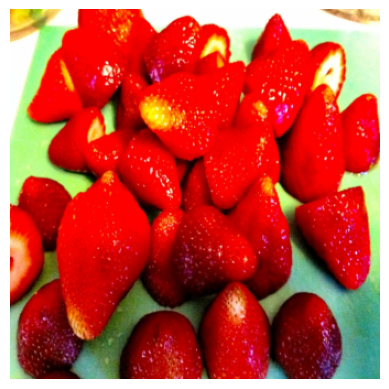

hypo: [CLS] in this image we can see some fruits. [SEP]
refe: [CLS] in this i can see there are red colored strawberries. [SEP]


hypo: [CLS] in this image we can see some fruits. [SEP]
refe: [CLS] in this i can see there are red colored strawberries. [SEP]
hypo: [CLS] in this image we can see a woman sitting on the chairs. in front of them there are sitting on the table. [SEP]
refe: [CLS] there are few persons sitting on the chairs. here we can see monitors, keyboards, tables, and devices. [SEP]
hypo: [CLS] in this image we can see a man is a woman standing on the background we can see a wall. [SEP]
refe: [CLS] this image is taken outdoors. at the bottom of the there is a floor. in the background there are a few buildings with walls, windows and balconies. in the middle of the image two men and a woman are standing on the floor and they are with smiling faces. [SEP]
hypo: [CLS] in this image we can see few plants and there are flowers. in the background there are plants. [SEP]
refe: [

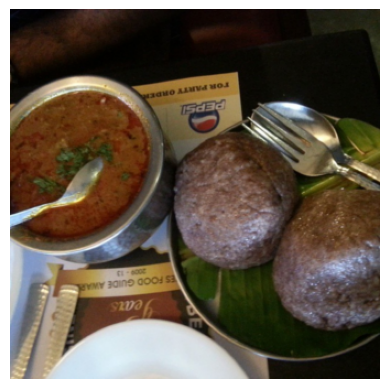

hypo: [CLS] in this image we can see some food items on the plate, we can see a plate, we can see a plate. [SEP]
refe: [CLS] in this picture there is a bowl and a plate in the center of the image, which contains food items in it. [SEP]


hypo: [CLS] in this image we can see some food items on the plate, we can see a plate, we can see a plate. [SEP]
refe: [CLS] in this picture there is a bowl and a plate in the center of the image, which contains food items in it. [SEP]
hypo: [CLS] in this image we can see a plate on the plate. [SEP]
refe: [CLS] in this picture i can observe some food places in the plate. the food is in brown, orange, green and red colors. it is looking like a burger. the background is completely blurred. [SEP]
hypo: [CLS] in this image we can see a man standing on the floor. in front of the background we can see a table. [SEP]
refe: [CLS] in this image i can see a person standing wearing a black shirt, blue jeans and glasses. he is holding a electronic gadget in his ha

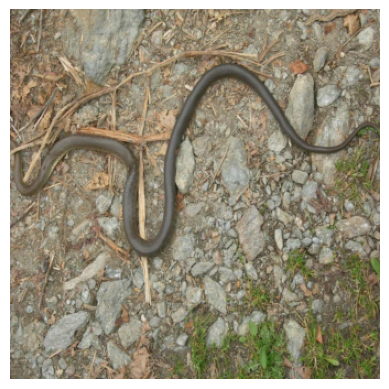

hypo: [CLS] in this image we can see a snake in the ground. [SEP]
refe: [CLS] in this image i can see a snake on the ground. it is in black color. i can see few wooden sticks, few stones and grass. [SEP]


hypo: [CLS] in this image we can see a snake in the ground. [SEP]
refe: [CLS] in this image i can see a snake on the ground. it is in black color. i can see few wooden sticks, few stones and grass. [SEP]
hypo: [CLS] in this image we can see a woman standing in front of the podium. in front of the podium. [SEP]
refe: [CLS] in this image we can see a person standing and holding a book and to the side we can see a podium with mic and there is a laptop and some other objects on the table. we can see a person standing in the bottom right. [SEP]
hypo: [CLS] in this image we can see a woman sitting on the ground. [SEP]
refe: [CLS] in this picture i can see 2 women in front and the women right is holding a brush in her hand and i see the paint on the face of the woman on the left and in the 

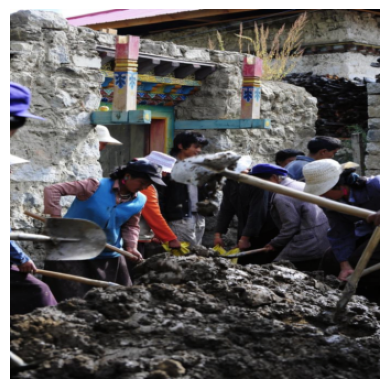

hypo: [CLS] in this image we can see a group of people standing on the ground. in their hands. in the background we can see a wall. [SEP]
refe: [CLS] in this image i can see the mud which is black in color and few persons holding mud in their hands. in the background i can see few other persons standing, the wall which is made up of rocks, the door, the building and the sky. [SEP]


hypo: [CLS] in this image we can see a group of people standing on the ground. in their hands. in the background we can see a wall. [SEP]
refe: [CLS] in this image i can see the mud which is black in color and few persons holding mud in their hands. in the background i can see few other persons standing, the wall which is made up of rocks, the door, the building and the sky. [SEP]
hypo: [CLS] in this image i can see a group of this image there are smiling. [SEP]
refe: [CLS] this is a black and white image of many children. few are smiling. [SEP]
hypo: [CLS] in this image we can see a person sitting on the t

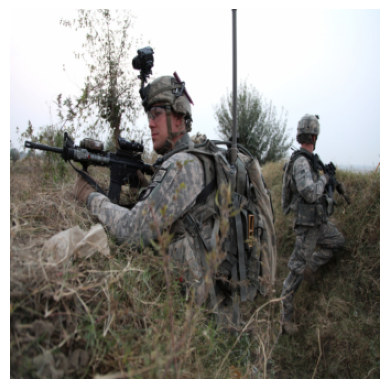

hypo: [CLS] in this image we can see few people standing on the ground. in the ground. in the ground. in the ground. [SEP]
refe: [CLS] in this image i can see two persons wearing uniforms bags and helmets are on the ground and i can see two of them are holding guns in their hands. i can see some grass and few trees. in the background i can see the sky. [SEP]


hypo: [CLS] in this image we can see few people standing on the ground. in the ground. in the ground. in the ground. [SEP]
refe: [CLS] in this image i can see two persons wearing uniforms bags and helmets are on the ground and i can see two of them are holding guns in their hands. i can see some grass and few trees. in the background i can see the sky. [SEP]
hypo: [CLS] in this image we can see an insect on the leaf. in the background there is blurred. [SEP]
refe: [CLS] in the picture we can see dragon fly which is on leaves of a plant and the leaves are in green color. [SEP]
hypo: [CLS] in this image we can see a group of people

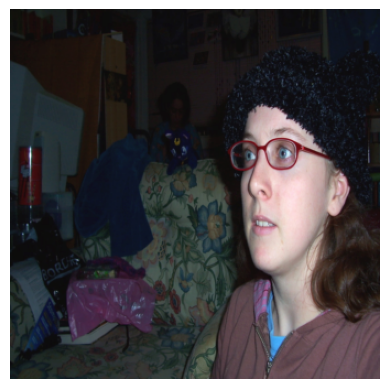

hypo: [CLS] in this image we can see a woman sitting on the image, we can see a woman sitting on the background we can see a wall. [SEP]
refe: [CLS] in this image i can see a person is wearing black color cap. back i can see few books, cover and few objects on the chair. back i can see few object and it is dark image. [SEP]


hypo: [CLS] in this image we can see a woman sitting on the image, we can see a woman sitting on the background we can see a wall. [SEP]
refe: [CLS] in this image i can see a person is wearing black color cap. back i can see few books, cover and few objects on the chair. back i can see few object and it is dark image. [SEP]
hypo: [CLS] in this image we can see a group of people sitting on the image there are sitting on the background we can see a wall. [SEP]
refe: [CLS] in the picture we can see some group of persons standing and most of them are holding cameras in their hands, in the middle of the picture there is a lady person holding leash of a horse which is i

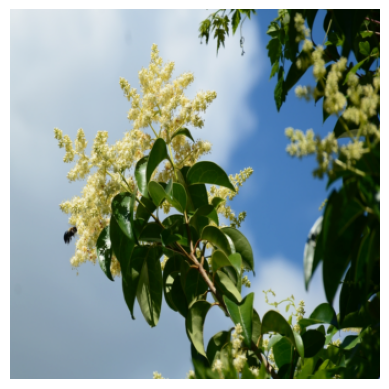

hypo: [CLS] in this image we can see a bird on the plant. in the background there are flowers. [SEP]
refe: [CLS] in this picture we can see mango tree. here we can see some flowers. on the background we can see sky and clouds. [SEP]


hypo: [CLS] in this image we can see a bird on the plant. in the background there are flowers. [SEP]
refe: [CLS] in this picture we can see mango tree. here we can see some flowers. on the background we can see sky and clouds. [SEP]
hypo: [CLS] in this image we can see a group of people sitting on the table there are sitting on the table. [SEP]
refe: [CLS] in this image i can see group of people sitting on chairs around the dining table. on the dining table i can see plates, bowls and boxes with food items in them. [SEP]
hypo: [CLS] in this image we can see a man is wearing a man standing on the background we can see a projector screen. [SEP]
refe: [CLS] in the image we can see there is a man standing, he is wearing formal suit and id card around his neck

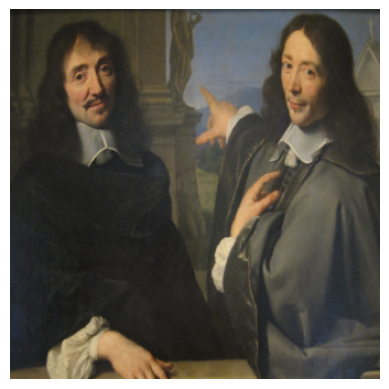

hypo: [CLS] in this image we can see a painting. in the background we can see a wall. [SEP]
refe: [CLS] this image is having the painting of two persons. behind them there is a wall having a statue. beside there are few plants and hill. right side there is a building. [SEP]


hypo: [CLS] in this image we can see a painting. in the background we can see a wall. [SEP]
refe: [CLS] this image is having the painting of two persons. behind them there is a wall having a statue. beside there are few plants and hill. right side there is a building. [SEP]
hypo: [CLS] in this image we can see a sculpture. [SEP]
refe: [CLS] this is a black and white image. in the middle of this image there is an idol. the background is in black color. [SEP]
hypo: [CLS] in this image we can see a man wearing a man is wearing spectacles. [SEP]
refe: [CLS] in this image we can see a man wearing the glasses and some flowers on his mustache. on the backside we can see some people. [SEP]
hypo: [CLS] in this image i can 

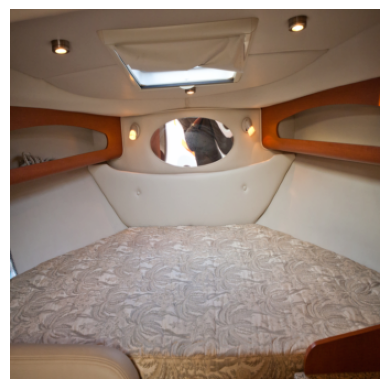

hypo: [CLS] in this image we can see an inside view of the image, we can see a wall. [SEP]
refe: [CLS] in this image there is a bed and in the background there is a mirror on the top there are lights and on the left side there is a shelf and on the shelf there is a rope. on the right side there is an empty shelf. [SEP]


hypo: [CLS] in this image we can see an inside view of the image, we can see a wall. [SEP]
refe: [CLS] in this image there is a bed and in the background there is a mirror on the top there are lights and on the left side there is a shelf and on the shelf there is a rope. on the right side there is an empty shelf. [SEP]
hypo: [CLS] in this image we can see few animals standing on the ground. in the ground. [SEP]
refe: [CLS] in this image we can see buffaloes running on the ground and we can see plants, grass and a tree are on the ground. [SEP]
hypo: [CLS] in this image we can see a baby. [SEP]
refe: [CLS] in the image there is a baby wrapped in a towel. [SEP]
hypo: [CLS

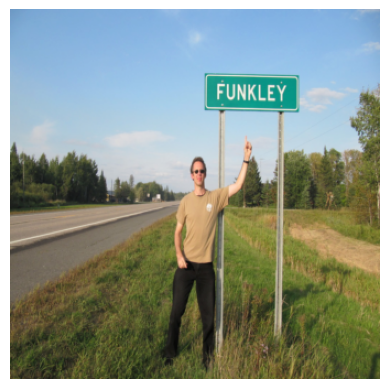

hypo: [CLS] in this image we can see a person standing on the image, we can see a board. in the background there are trees. [SEP]
refe: [CLS] here we can see a man standing on the grass. this is a road. there are trees, poles, and a board. in the background there is sky with clouds. [SEP]


hypo: [CLS] in this image we can see a person standing on the image, we can see a board. in the background there are trees. [SEP]
refe: [CLS] here we can see a man standing on the grass. this is a road. there are trees, poles, and a board. in the background there is sky with clouds. [SEP]
hypo: [CLS] in this image we can see an insect. [SEP]
refe: [CLS] in this image i can see an insect which is colorful. it is on the white color surface. [SEP]
hypo: [CLS] in this image we can see a snow on the snow on the image there are trees, snow. [SEP]
refe: [CLS] in this image there are buildings and trees. at the bottom there is snow. in the background there are wires and sky. there is a pole. [SEP]
hypo: [CL

In [11]:
test_num = 80
batch_size = 8

model_name = "distilbert-base-uncased"

pad_token_id = tokenizer.pad_token_id

my_decode = False
#my_decode = True

# Subset samplerの生成
test_set, val_set, train_set = util.generate_subset_test_val_train(
    train_dataset, 0.1, 0.1 )

test_set = test_set[:test_num]

test_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    #batch_size=config.batch_size,
                    batch_size=batch_size,
                    num_workers=0,
                    sampler=test_set,
                    collate_fn=collate_func_lambda)

test_pr_coef = 1

fn = bleu_score.SmoothingFunction().method7

transforms_inv = v2.Compose([
    v2.Normalize((-0.48145466/0.26862954, -0.4578275/0.26130258, -0.40821073/0.27577711), (1/0.26862954,1/0.26130258,1/0.27577711)),
    v2.ToPILImage()
])

# test
with tqdm(test_loader) as pbar:
    pbar.set_description(f'[テスト]')

    # 評価モード
    model.eval()

    test_ciders = deque()
    test_rouges = deque()
    test_clips = deque()
    test_berts = deque()
    n_iter = 0
    for k, (imgs, imgs2, captions, caption_lengths) in enumerate( pbar ):
        print( "k:", k )
        imgs = imgs.to(device)
        captions = captions.to(device)
        #caption_lengths = torch.tensor( caption_lengths ).to(config.device)
        
        with torch.no_grad():
            finalized_scores, finalized_tokens = model.inference( imgs, inf_t = 'v' )
            hypo_ids = finalized_tokens
        
        n = 0
        hypo_sentence = []
        ref_sentence = []
        ref_imgs = []
        total_error = 0
        total_token_length = 0
        total_bleu = 0
        preds_str = [
            tokenizer.decode([i for i in pred if i != eos_token_id \
            and i != pad_token_id ] ) 
            for pred in hypo_ids
        ]
        preds_str2 = [
            tokenizer.decode([i for i in pred if i != eos_token_id], skip_special_tokens=True) 
            for pred in hypo_ids
        ]
        targets_str = [tokenizer.decode(
            [ i for i in target \
            if i != pad_token_id \
             and i != eos_token_id ]       
            ) for target in captions]
        hypo_tokens = tokenizer.tokenize( preds_str[0] )
        ref_tokens = tokenizer.tokenize( targets_str[0] )

        pred_dict = { str(i): [item] for i, item in enumerate( preds_str)}
        target_dict = { str(i): [item] for i, item in enumerate( targets_str)}
        avg_cider, scores = compute_reward.scorer.compute_score(target_dict, pred_dict) # cider の計算        
        rouge_scores = [compute_reward.rougeL.score(target, pred)['rougeL'][0] for pred, target in zip(preds_str, targets_str)]
        avg_rouge = sum( rouge_scores ) / len( rouge_scores )
        clip_scores = [compute_reward.metric( img2, pred).detach() for img2, pred in zip( imgs2, preds_str2 )]
        clip_score = sum( clip_scores ) / len( clip_scores ) / 100.0
        bert_scores = compute_reward.bert.compute(predictions=preds_str, references=targets_str, model_type=model_name, \
                                                              lang='en',  device=device)['f1']
        bert_scores = [score for score in bert_scores]
        bert_score = sum( bert_scores ) / len( bert_scores )
            
        ## 認識誤りを計算
        #(error, substitute, delete, insert, ref_length) = levenshtein.calculate_error(hypo_tokens,ref_tokens)
        
        ## 誤り文字数を累積する
        #total_error += error
        ## 文字の総数を累積する
        #total_token_length += ref_length


        inv_img = transforms_inv( imgs[0])
        plt.imshow( inv_img )
        plt.axis('off')
        plt.show()
        print( "hypo:", preds_str[0] )
        print( "refe:", targets_str[0] )
        print( "\n" )
        
        for pred, target in zip( preds_str, targets_str ):
            print( "hypo:", pred )
            print( "refe:", target )
  
        print( "these pics. cider :", avg_cider )
        print( "these pics. rouge:", avg_rouge )
        print( "these pics. clip_score:", clip_score )
        print( "these pics. bert_score:", bert_score )
        test_ciders.append(avg_cider)
        test_rouges.append(avg_rouge)
        test_clips.append(clip_score)
        test_berts.append(bert_score)
        n_iter += 1
        print(f'test number = {n_iter} average, cider = {torch.Tensor(test_ciders).mean().item()}, ' \
                f'rouge = {torch.Tensor(test_rouges).mean().item()}, clip_score = {torch.Tensor(test_clips).mean().item()}, ' \
                f'bert_score = {torch.Tensor(test_berts).mean().item()}' )
        print( "\n\n" )
        
            
        #if len(test_errors) > config.moving_avg:
        if len(test_ciders) > 100:
            test_ciders.popleft()
            test_rouges.popleft()
            test_clips.popleft()
            test_berts.popleft()
        pbar.set_postfix({
            #'loss': torch.Tensor(test_losses).mean().item(),
            'cider': torch.Tensor(test_ciders).mean().item(),
            'rougeL': torch.Tensor(test_rouges).mean().item(),
            'clip_score': torch.Tensor(test_clips).mean().item(),
            'bert_score': torch.Tensor(test_berts).mean().item()
        })                

# 表示
test_cider = np.mean( test_ciders )
test_rouge = np.mean( test_rouges )
test_clip = np.mean( test_clips )
test_bert = np.mean( test_berts )
print(f'test {n_iter} * {batch_size} average cider : {test_cider}')
print(f'test {n_iter} * {batch_size} average rougeL: {test_rouge}')
print(f'test {n_iter} * {batch_size} average clip_score: {test_clip}')
print(f'test {n_iter} * {batch_size} average bert_score: {test_bert}')